In [1]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
data  = pd.read_csv("data/featureslogfile_Budget_500_vs_Budget_500_GPM100_SD_NoSelfPlay.txt", sep = '\t')
#data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces.txt", sep = ' ')
print(data)
print(data.columns)

       GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0         2.0     0.0    0.0   0.0           4.0   0.08       0.04      0.5   
1         2.0     1.0    0.0   0.0           3.0   0.06      -0.04      1.0   
2         2.0     0.0    0.0   1.0           4.0   0.08       0.04      0.5   
3         2.0     1.0    0.0   1.0           3.0   0.06      -0.04      1.0   
4         2.0     0.0    1.0   0.0           4.0   0.08       0.04      0.5   
...       ...     ...    ...   ...           ...    ...        ...      ...   
23833   201.0     1.0   50.0   1.0          83.0   1.66       1.12      0.5   
23834   201.0     0.0   51.0   0.0          55.0   1.10      -1.12      1.0   
23835   201.0     1.0   51.0   0.0          83.0   1.66       1.12      0.5   
23836   201.0     0.0   51.0   1.0          55.0   1.10      -1.36      1.0   
23837   201.0     1.0   51.0   1.0          89.0   1.78       1.36      0.5   

       OUR_TURN  HAS_WON  ...  SENTRY  WITCH  ARTIS

In [3]:
#data = data[data['GameID']!=1000]

In [4]:
#LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
LOGS_FROM_TAG = True

#choose whether or not to normalise playtraces so that each vector has a length of one
USE_UNIT_VECTOR_PLAYTRACES = False

#choose whether to make each deck vector entry between zero and one
USE_UNIT_CARD_COUNTS = False

#decide whether or not to remove outliers
REMOVE_OUTLIERS = True

NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
#agents = ['BMWG', 'DW']
#agents = ['MCTS_Medium_A', 'MCTS_Medium_B'] #arbitrary labels for players (whether AI based or not)
agents = ['PlayerA', 'PlayerB']

#if using TAG, parameters for round robin tournament
games_per_matchup = 100
self_play = False
#NoOfGames = 2 * games_per_matchup
NoOfGames = len(data['GameID'].unique())
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

In [5]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
#card_types_SD_reduced = ['GARDENS', 'WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD_reduced = ['CURSE']
#card_types = card_types_SD_reduced 
#card_types = card_types_FG1E
card_types = card_types_SD
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore', 'TotalRounds'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [6]:
#label all games with corresponding agent names

if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [7]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

[0. 1.]


In [8]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

       Player  GameID AgentName  Win  FinalScore  TotalRounds  Round  ARTISAN  \
2         0.0     2.0   PlayerA  0.0        29.0         17.0    0.0      0.0   
3         1.0     2.0   PlayerB  1.0        33.0         17.0    0.0      0.0   
6         0.0     2.0   PlayerA  0.0        29.0         17.0    1.0      0.0   
7         1.0     2.0   PlayerB  1.0        33.0         17.0    1.0      0.0   
10        0.0     2.0   PlayerA  0.0        29.0         17.0    2.0      0.0   
...       ...     ...       ...  ...         ...          ...    ...      ...   
23829     1.0   201.0   PlayerA  1.0        89.0         51.0   49.0      0.0   
23832     0.0   201.0   PlayerB  0.0        55.0         51.0   50.0      0.0   
23833     1.0   201.0   PlayerA  1.0        89.0         51.0   50.0      0.0   
23836     0.0   201.0   PlayerB  0.0        55.0         51.0   51.0      0.0   
23837     1.0   201.0   PlayerA  1.0        89.0         51.0   51.0      0.0   

       BANDIT  BUREAUCRAT  

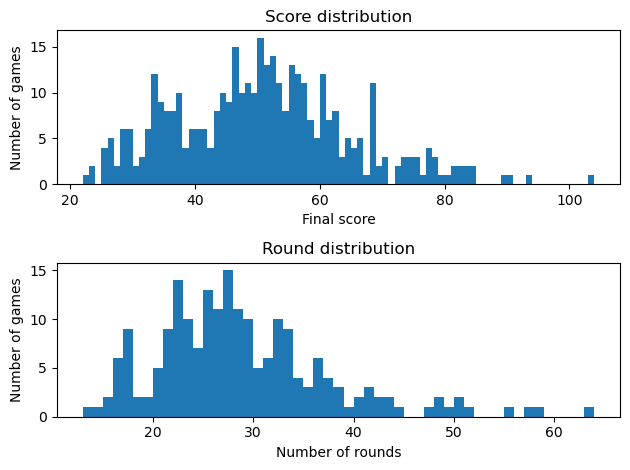

In [9]:
#plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = traces.groupby('GameID')['Round'].max()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

No traces before outlier removal: 11788
No traces after outlier removal: 11788
Percentage remaining of original data set: 1.0


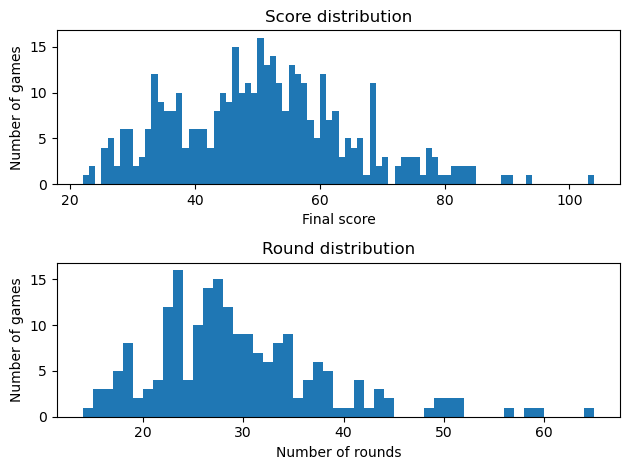

In [10]:
#remove outliers based on thresholds for score and length of game
#score_threshold = 80
#round_threshold = 46
score_threshold = 300
round_threshold = 300
traces_no_outliers = traces[(traces['FinalScore'] <= score_threshold)
                                           & (traces['TotalRounds'] <= round_threshold)]
#then re-plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces_no_outliers.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = grouped_data['TotalRounds'].unique().explode()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

print("No traces before outlier removal: " + str(len(traces)))
print("No traces after outlier removal: " + str(len(traces_no_outliers)))
print("Percentage remaining of original data set: " + str(len(traces_no_outliers)/(1.0*len(traces)))) 

In [11]:
if REMOVE_OUTLIERS:
    traces = traces_no_outliers
    NoOfGames = len(traces['GameID'].unique())

In [12]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

65


In [13]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [14]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*NoOfGames))
print("Expected no of cols: " + str(len(card_types)+7))
print(extended_traces.shape)

       Player  GameID AgentName  Win  FinalScore  TotalRounds  Round  ARTISAN  \
0         0.0     2.0   PlayerA  0.0        29.0         17.0    0.0      0.0   
1         1.0     2.0   PlayerB  1.0        33.0         17.0    0.0      0.0   
2         0.0     2.0   PlayerA  0.0        29.0         17.0    1.0      0.0   
3         1.0     2.0   PlayerB  1.0        33.0         17.0    1.0      0.0   
4         0.0     2.0   PlayerA  0.0        29.0         17.0    2.0      0.0   
...       ...     ...       ...  ...         ...          ...    ...      ...   
25995     1.0   201.0   PlayerA  1.0        89.0         51.0   62.0      0.0   
25996     0.0   201.0   PlayerB  0.0        55.0         51.0   63.0      0.0   
25997     1.0   201.0   PlayerA  1.0        89.0         51.0   63.0      0.0   
25998     0.0   201.0   PlayerB  0.0        55.0         51.0   64.0      0.0   
25999     1.0   201.0   PlayerA  1.0        89.0         51.0   64.0      0.0   

       BANDIT  BUREAUCRAT  

In [15]:
#next if required we convert all entries ot values between zero and one
#to do this for each round we look at the maximum number of card tyoes for that round
#and divide all card amounts for that card type and for that round by the maximum

def normalise_card_counts(row, maxCardByType, cardTypes, maxRounds):
    for card in cardTypes:
        max_val = 1
        if maxCardByType[maxRounds-1][card] > 0:
            max_val = maxCardByType[maxRounds-1][card]
        row[card] = row[card]/max_val
    return row

max_card_by_type = {}
if USE_UNIT_CARD_COUNTS:
    for round_no in range(0, maxNoOfRounds):
        max_card_by_type[round_no] = {}
        for card in card_types:
            tmp = extended_traces[extended_traces['Round'] == round_no]
            max_card_by_type[round_no][card] = tmp[card].max()
            #pdb.set_trace()
    
    #next divide each card amount by the maximum value
    extended_traces = extended_traces.apply(lambda row: normalise_card_counts(row, max_card_by_type, card_types, maxNoOfRounds), axis = 1) 

In [16]:
#next we need to flatten this dataframe so that each trace is a single row.
#We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names

#given a dictionary whose elements are lists of length two, grab the other element not given by elem, used in code
#below
def other_dict_element(my_dict, my_key, my_elem):
    index_of_given_element = my_dict[my_key].index(my_elem)
    index_of_other_element =  1 if (index_of_given_element == 0) else 0
    return my_dict[my_key][index_of_other_element]

#first create dataframe consisting of only non card type data types that are round 
#independent
non_card_data_round_indep = extended_traces[index_cols + non_card_types_round_indep_cols].drop_duplicates()

#next need to Group by Player and GameID and then flatten card data by round
traces_tmp = extended_traces[index_cols + card_types]
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = index_cols + cols

#next we add back in the round independent data
extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)
                                 
#finally we also add the name of the agent of the opponent 
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
if LOGS_FROM_TAG:
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)  
else:
    gameid_to_players_dict = extended_traces_flat.groupby('GameID')['AgentName'].apply(list).to_dict()
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: 
                            other_dict_element(gameid_to_players_dict, row['GameID'], row['AgentName']), axis = 1)   

In [17]:
#prepare data for clustering approaches
tmp =  index_cols + non_card_types_round_indep_cols
tmp  = tmp + ['Opponent','AgentNameOpponent']
trace_X = extended_traces_flat.drop(tmp, axis = 1)

#alos create a normalised set pf playtraces 
def normalize_row(row):
    norm = np.linalg.norm(row)  # Compute the L2 norm of the row
    if norm != 0:
        return row / norm
    else:
        return row
    
trace_X_normalised = trace_X.apply(lambda row: normalize_row(row), axis = 1)

#choose whether or not to normalise playtraces
if USE_UNIT_VECTOR_PLAYTRACES:
    trace_X = trace_X_normalised

In [18]:
def sa_kmeans(data, num_clusters):
    clusterer = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(data)
    cluster_labels = clusterer.fit_predict(trace_X)
    return silhouette_score(data, cluster_labels)
    
def sa_dbscan(data, minPts = 5, epsilon = 0.3, outputplot = False):
    neighbors = NearestNeighbors(n_neighbors= minPts)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    if outputplot:
        #Sort distance values by ascending value and plot
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        plt.plot(distances)
        plt.xlabel('Playtrace instance')
        plt.ylabel('Average distance to minPts neighbours')
        plt.title('K-Nearest neighbours')
    
    dbscan_clustering = DBSCAN(eps= epsilon, min_samples= minPts).fit(data)
    
    if len(np.unique(dbscan_clustering.labels_)) == 1:
        return None
    else:
        return silhouette_score(data, dbscan_clustering.labels_)
    
def sa_spectral_clustering_KNN(data, num_clusters, num_nearest_neighbours):
    #here the affinity matrix is based on K-NN
    spec_clustering_knn = SpectralClustering(n_clusters= num_clusters,
                                             random_state=0,
                                             affinity = 'nearest_neighbors',
                                             n_neighbors = num_nearest_neighbours,
                                             assign_labels='kmeans').fit(data)  
    if len(np.unique(spec_clustering_knn.labels_)) == 1:
        return None
    else:
        return silhouette_score(data, spec_clustering_knn.labels_)

def sa_spectral_clustering_RBF(data, num_clusters, gamma_val = 0.4):
    spec_clustering_rbf = SpectralClustering(n_clusters= num_clusters,
                                         random_state=0,
                                         gamma = gamma_val,
                                         affinity = 'rbf',
                                         assign_labels='kmeans').fit(data)
    if len(np.unique(spec_clustering_rbf.labels_)) == 1:
        return None
    else:
        return silhouette_score(data, spec_clustering_rbf.labels_)

In [19]:
#next we consider  different methods and produce a silhouette average for each method

#kmeans
sa_kmeans_results = {}
for n_clusters in range(2,6):
    tmp = sa_kmeans(trace_X, n_clusters)
    sa_kmeans_results[n_clusters] = sa_kmeans(trace_X, n_clusters)
    
#output results
print("Kmeans:")
print("All silhouette averages: ")
print(sa_kmeans_results)
print("Best silhouette average:")
max_key = max(sa_kmeans_results, key=lambda k: sa_kmeans_results[k])
max_value = sa_kmeans_results[max_key]
print("Clusters: " + str(max_key) + " SA: " + str(max_value))

#DBSCAN
sa_dbscan_results = {}
for minpts in range(5, 30, 5):
    sa_dbscan_results[minpts] = {}
    for epsilon in np.arange(0.1, 1, 0.1):
        sa_dbscan_results[minpts][epsilon] = sa_dbscan(trace_X_normalised, minpts, epsilon)
        
print("DBSCAN:")
print("All silhouette averages: ")
print(sa_dbscan_results)
print("Best silhouette average:")
max_sa = 0
max_minpts = 0
max_eps = 0
for minpts, eps_dict in sa_dbscan_results.items():
      for eps, sa_value in eps_dict.items():
        if (sa_value != None) and (sa_value > max_sa):
            max_sa = sa_value
            max_minpts = minpts
            max_eps = eps
print("Minpts: " + str(max_minpts) + " espilon: " + str(max_eps) + " SA: " + str(max_sa))

#Spectral Clustering using KNN
sa_spectral_knn_results = {}
for n_clusters in range(2,5):
    sa_spectral_knn_results[n_clusters] = {}
    for num_NN in range(5,50,5):
        sa_spectral_knn_results[n_clusters][num_NN] = sa_spectral_clustering_KNN(trace_X, n_clusters, num_NN)

print("Spectral Clustering - KNN:")
print("All silhouette averages: ")
print(sa_spectral_knn_results)
print("Best silhouette average:")
max_sa = 0
max_clusters = 0
max_NN = 0
for clusters, nn_dict in sa_spectral_knn_results.items():
      for nn, sa_value in nn_dict.items():
        if (sa_value != None) and (sa_value > max_sa):
            max_sa = sa_value
            max_clusters = clusters
            max_NN = nn
print("Clusters: " + str(max_clusters) + " Nearest Neighbours: " + str(max_NN) + " SA: " + str(max_sa))        
        
#Spectral Clustering using RBF
sa_spectral_rbf_results = {}
for n_clusters in range(2,5):
    sa_spectral_rbf_results[n_clusters] = {}
    for gamma in np.arange(0.1, 1, 0.1):
        sa_spectral_rbf_results[n_clusters][gamma] = sa_spectral_clustering_RBF(trace_X, n_clusters, gamma)

print("Spectral Clustering - RBF: ")
print("All silhouette averages: ")
print(sa_spectral_rbf_results)
print("Best silhouette average:")
max_sa = 0
max_clusters = 0
max_gamma = 0
for clusters, gamma_dict in sa_spectral_rbf_results.items():
      for gamma, sa_value in gamma_dict.items():
        if (sa_value != None) and (sa_value > max_sa):
            max_sa = sa_value
            max_clusters = clusters
            max_gamma = gamma
print("Clusters: " + str(max_clusters) + " Gamma: " + str(max_gamma) + " SA: " + str(max_sa))

Kmeans:
All silhouette averages: 
{2: 0.2938217688937184, 3: 0.2423026939562716, 4: 0.17891015968704124, 5: 0.1486191295467528}
Best silhouette average:
Clusters: 2 SA: 0.2938217688937184
DBSCAN:
All silhouette averages: 
{5: {0.1: None, 0.2: 0.03151815650836918, 0.30000000000000004: 0.09254865438572984, 0.4: None, 0.5: None, 0.6: None, 0.7000000000000001: None, 0.8: None, 0.9: None}, 10: {0.1: None, 0.2: -0.07477340243650847, 0.30000000000000004: 0.08758503273824692, 0.4: None, 0.5: None, 0.6: None, 0.7000000000000001: None, 0.8: None, 0.9: None}, 15: {0.1: None, 0.2: 0.1606036888019149, 0.30000000000000004: 0.07034400717979242, 0.4: None, 0.5: None, 0.6: None, 0.7000000000000001: None, 0.8: None, 0.9: None}, 20: {0.1: None, 0.2: None, 0.30000000000000004: 0.06554484137703626, 0.4: None, 0.5: None, 0.6: None, 0.7000000000000001: None, 0.8: None, 0.9: None}, 25: {0.1: None, 0.2: None, 0.30000000000000004: 0.07114137443687461, 0.4: None, 0.5: None, 0.6: None, 0.7000000000000001: None, 0

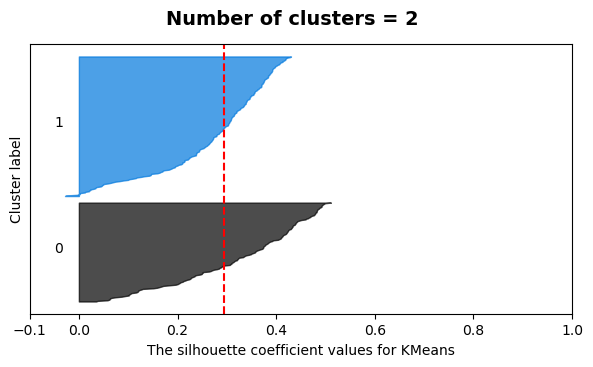

In [20]:
#plot silhouette scores for a given clustering method
clustering_method = "KMeans"
num_clusters = 2
gamma_val = 0.3
num_nearest_neighbours = 35
epsilon = 0.3
minPts = 10
clusterer_Kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)
#clusterer_RBF =  SpectralClustering(n_clusters= num_clusters,random_state=0,gamma = gamma_val,affinity = 'rbf',assign_labels='kmeans').fit(trace_X)
#clusterer_KNN = SpectralClustering(n_clusters= num_clusters,random_state=0,affinity = 'nearest_neighbors',n_neighbors = num_nearest_neighbours,assign_labels='kmeans').fit(trace_X)  
#clusterer_DBSCAN =  DBSCAN(eps= epsilon, min_samples= minPts).fit(trace_X)

clusterer = clusterer_Kmeans
#clusterer = clusterer_KNN
#clusterer = clusterer_RBF
#clusterer = clusterer_DBSCAN

cluster_labels = clusterer.fit_predict(trace_X)
sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)
silhouette_avg = silhouette_score(trace_X, cluster_labels)

# Create a subplot with 1 row and 1 columns
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(7, 3.5)

y_lower = 10
for i in range(num_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusterer.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values for " + str(clustering_method))
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(
    #"Silhouette analysis for " + str(clustering_method) + " clustering on sample data with n_clusters = %d"
    "Number of clusters = %d"
    % num_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [21]:
#look at deck evolution for clusters